In [ ]:
import transforms as transforms
import population as population
import optimize as optimize
import utility as utility
import pandas as pd
import numpy as np
import visualization as visualization
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import evaluation as evaluation


data = pd.read_csv("../../data/ES15.csv")
x_raw = data.values

#x_raw, x_ind = train_test_split(x_raw_presplit, test_size=0.1, shuffle=False)

dirpath = utility.fetch_new_run_dirpath()



pop = population.generate_random_forest(100, 12)

np.seterr(all='ignore')
best_forest, best_scores, best_overtime = optimize.optimize_constants(
    pop, x_raw, sthresh_q=.1, run_dir=dirpath, max_iter=2, vizout=False
)

img = visualization.visualize_tree(best_forest[best_scores.index(min(best_scores))], run_dir=dirpath, vizout=True)
best_forest , best_scores = population.extract_n_best_trees(best_forest, best_scores, -1, run_dir=dirpath, vizout=True)


ynew = np.roll(x_raw[:, 3], shift=-1)
y_ = np.log(ynew / x_raw[:, 3])
#np.random.shuffle(y_)


x_ = transforms.forest2features(
    population=best_forest,
    x_raw=x_raw
)

#using time column (never utilized) as noise column
x_raw[:, 0] = 1
noise = np.random.rand(x_raw.shape[0], 1)

x_ = np.hstack([x_, noise])


X_train, X_test, y_train, y_test = train_test_split(x_, y_, test_size=0.3, shuffle=True)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = evaluation.standard_NN_construction(X_train, y_train, verbose=1)
evaluation.standard_LM_evaluation(X_train, X_test, y_train, y_test, model, dirpath, vizout=True, show=True)
#evaluation.standard_LM_evaluation(X_train, xind_, y_train, yind_, model, dirpath, vizout=True)

In [ ]:
import transforms as transforms
import population as population
import optimize as optimize
import utility as utility
import pandas as pd
import numpy as np
import visualization as visualization
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import evaluation as evaluation


data = pd.read_csv("../../data/ES15.csv")
x_raw = data.values

#x_raw, x_ind = train_test_split(x_raw_presplit, test_size=0.1, shuffle=False)

dirpath = utility.fetch_new_run_dirpath()



pop = population.generate_random_forest(200, 12)

np.seterr(all='ignore')
best_forest, best_scores, best_overtime = optimize.optimize_constants(
    pop, x_raw, sthresh_q=.1, run_dir=dirpath, max_iter=-1, vizout=True
)

img = visualization.visualize_tree(best_forest[best_scores.index(min(best_scores))], run_dir=dirpath, vizout=True)
best_forest , best_scores = population.extract_n_best_trees(best_forest, best_scores, 10, run_dir=dirpath, vizout=True)


ynew = np.roll(x_raw[:, 3], shift=-1)
y_ = np.log(ynew / x_raw[:, 3])
#np.random.shuffle(y_)


x_ = transforms.forest2features(
    population=best_forest,
    x_raw=x_raw
)


#noise = np.random.rand(x_raw.shape[0], 1)
#x_ = np.hstack([x_, noise])


X_train, X_test, y_train, y_test = train_test_split(x_, y_, test_size=0.3, shuffle=True)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.optimizers.schedules import ExponentialDecay

def standard_NN_construction(X_train, y_train, epochs=250, verbose=0):
    

    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.65, 
        patience=3, 
        min_lr=1e-6
    )
    early_stopping = EarlyStopping(monitor='loss', patience=25, mode='min', restore_best_weights=True)

    opt  = tf.keras.optimizers.Adam()
    opt2 = tf.keras.optimizers.SGD(learning_rate=0.01)

    def build_model():
        model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(X_train.shape[1],)),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(64, activation='relu'),  
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(64, activation='relu'),       
            tf.keras.layers.Dense(1, activation='linear')  # Output layer for regression
        ])
        
        rmse='root_mean_squared_error'

        model.compile(optimizer=opt2, loss='mse', metrics=['R2Score'])
        return model

    with tf.device('/GPU:0'):
        model = build_model()
        history = model.fit(X_train, y_train, epochs=epochs, batch_size=512, \
                        validation_split=0.2, verbose=verbose, shuffle=True, callbacks=[reduce_lr, early_stopping])
        
    return model, history

In [ ]:
import reproduction
best_forest = reproduction

In [ ]:
import transforms, evaluation
import pandas as pd
import numpy as np
data = pd.read_csv("../../data/ES15.csv")
x_raw = data.values
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

ynew = np.roll(x_raw[:, 3], shift=-1)
y_ = np.log(ynew / x_raw[:, 3])
#np.random.shuffle(y_)

import serialization

best_forest = serialization.load_forest(where='../../runs/run_5/best.4st')

x_ = transforms.forest2features(
    population=best_forest,
    x_raw=x_raw
)


#noise = np.random.rand(x_raw.shape[0], 1)
#x_ = np.hstack([x_, noise])


X_train, X_test, y_train, y_test = train_test_split(x_, y_, test_size=0.3, shuffle=True, random_state=0)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
model = evaluation.standard_LM_construction(X_train, y_train)
evaluation.standard_LM_evaluation(X_train, X_test, y_train, y_test, model, '', vizout=False, show=True)

In [59]:
import visualization, serialization, transforms
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
data = pd.read_csv("../../data/ES15_ext.csv")
x_raw = data.values

best_trees = []

for i in range(34, 124):
    print('run',i)
    where =str(i)

    try:
        forest = 	serialization.load_forest(	where=str('../../runs/run_'+where+'/best.4st'))
        path_scrs = serialization.load_deeplist(where=str('../../runs/run_'+where+'/path_pscr.hstry'))

    except Exception:
        continue

    best_trees.append(forest[0])

'''    print(path_scrs[0][-1])
    art_thresh, ln_plratio = path_scrs[0][-1][0], path_scrs[0][-1][1]
    import evaluation

    pl_arr = evaluation.generate_pl_atrplr(x_raw, art_thresh, ln_plratio)
    x_ = transforms.forest2features(
        population=forest,
        x_raw=x_raw
    )
    bestpls, bestsums, bestthresh = evaluation.evaluate_tree_atrplr_pl(x_, pl_arr)
    #fig, ax = visualization.visualize_cumulative_first_feature_pl(best_pls=bestpls)

    from sklearn.metrics import precision_score

    if('>' in bestthresh[0]):

        preds = x_[:, 0] >0
    else:
        preds = x_[:, 0] <0
    trues = evaluation.generate_solarr_atrplr(x_raw, art_thresh, ln_plratio)
    idx = ~np.isnan(trues)

    best_trees.append(preds)

    ps = precision_score(trues[idx], preds[idx])
    #print('precision: ',ps)
    R = float(np.exp(ln_plratio))
    print('EV: ', (R * ps - ( 1 - ps )))
    #plt.show()'''

run 34
run 35
run 36
run 37
run 38
run 39
run 40
run 41
run 42
run 43
run 44
run 45
run 46
run 47
run 48
run 49
run 50
run 51
run 52
run 53
run 54
run 55
run 56
run 57
run 58
run 59
run 60
run 61
run 62
run 63
run 64
run 65
run 66
run 67
run 68
run 69
run 70
run 71
run 72
run 73
run 74
run 75
run 76
run 77
run 78
run 79
run 80
run 81
run 82
run 83
run 84
run 85
run 86
run 87
run 88
run 89
run 90
run 91
run 92
run 93
run 94
run 95
run 96
run 97
run 98
run 99
run 100
run 101
run 102
run 103
run 104
run 105
run 106
run 107
run 108
run 109
run 110
run 111
run 112
run 113
run 114
run 115
run 116
run 117
run 118
run 119
run 120
run 121
run 122
run 123


"    print(path_scrs[0][-1])\n    art_thresh, ln_plratio = path_scrs[0][-1][0], path_scrs[0][-1][1]\n    import evaluation\n\n    pl_arr = evaluation.generate_pl_atrplr(x_raw, art_thresh, ln_plratio)\n    x_ = transforms.forest2features(\n        population=forest,\n        x_raw=x_raw\n    )\n    bestpls, bestsums, bestthresh = evaluation.evaluate_tree_atrplr_pl(x_, pl_arr)\n    #fig, ax = visualization.visualize_cumulative_first_feature_pl(best_pls=bestpls)\n\n    from sklearn.metrics import precision_score\n\n    if('>' in bestthresh[0]):\n\n        preds = x_[:, 0] >0\n    else:\n        preds = x_[:, 0] <0\n    trues = evaluation.generate_solarr_atrplr(x_raw, art_thresh, ln_plratio)\n    idx = ~np.isnan(trues)\n\n    best_trees.append(preds)\n\n    ps = precision_score(trues[idx], preds[idx])\n    #print('precision: ',ps)\n    R = float(np.exp(ln_plratio))\n    print('EV: ', (R * ps - ( 1 - ps )))\n    #plt.show()"

In [66]:
from pathlib import Path as path
serialization.save_forest(best_trees, name='allruns.4st',dirpath=path.cwd())

forest saved.


In [2]:
import visualization, serialization, transforms, evaluation
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
data = pd.read_csv("../../data/ES15_ext.csv")
x_raw = data.values
from pathlib import Path as path
best_trees = serialization.load_deeplist(where='best.votes')
xall = np.asarray(best_trees).T

2025-08-19 14:45:36.489256: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-19 14:45:36.500515: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-19 14:45:36.583594: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-19 14:45:36.660382: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755629136.736841     932 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755629136.75

In [8]:
xall = np.asarray(best_trees).T
xall.shape

(8525, 36)

In [25]:
serialization.save_deeplist(best_trees, name='best_ext.votes', dirpath=path.cwd())

deep list saved.


In [37]:
x_raw.shape

(8525, 5)

In [ ]:
import serialization
data = serialization.load_deeplist(where='../../runs/run_132/ensemble.data')
e_forest = data[0]
e_params = data[1]
e_freqs = data[2]
e_EVs = data[3]

In [27]:
e_freqs[-1]

np.float64(0.14797905487277133)

In [ ]:
import transforms
import evaluation
import numpy as np
import pandas as pd

data = pd.read_csv("../../data/ES15.csv")
x_raw = data.values
data_ext = pd.read_csv("../../data/ES15_ext.csv")
x_raw_ext = data_ext.values

xall = transforms.forest2features(e_forest, x_raw)
xall_ext = transforms.forest2features(e_forest, x_raw_ext)

R = np.exp(np.mean(e_params[1]))
r = np.mean(e_params[0])


ytrue = evaluation.generate_solarr_atrplr(x_raw, r, np.log(R))
idx = ~np.isnan(ytrue)
ytrue = ytrue[idx]
xall = xall[idx]

yext = evaluation.generate_solarr_atrplr(x_raw_ext, r, np.log(R))
idx_ext = ~np.isnan(yext)
yext = yext[idx_ext]
xall_ext = xall_ext[idx_ext]

In [67]:
import numpy as np
import matplotlib.pyplot as plt

# ---------- helpers ----------
def _ev_from_counts(tp, fp, R: float) -> float:
    k = tp + fp
    if k == 0:
        return -1.0  # no predicted positives -> EV from precision=0 → -1
    ps = tp / k
    return R * ps - (1 - ps)

def _perm_pvalue_ev(y_true, y_pred, R: float, n_perm=5000, seed=None):
    """
    One-sided Monte Carlo p-value for EV: P(EV_perm >= EV_actual).
    Keep predictions fixed; shuffle labels.
    """
    y = np.asarray(y_true).astype(int)
    yhat = np.asarray(y_pred).astype(int)
    mask = ~np.isnan(y)
    y = y[mask]; yhat = yhat[mask]

    mpos = (yhat == 1)
    tp_actual = int((y[mpos] == 1).sum())
    fp_actual = int((y[mpos] == 0).sum())
    ev_actual = _ev_from_counts(tp_actual, fp_actual, R)

    rng = np.random.default_rng(seed)
    ge = 0
    for _ in range(n_perm):
        y_perm = rng.permutation(y)
        tp = int((y_perm[mpos] == 1).sum())
        fp = int((y_perm[mpos] == 0).sum())
        ev = _ev_from_counts(tp, fp, R)
        if ev >= ev_actual:
            ge += 1
    return (ge + 1.0) / (n_perm + 1.0), ev_actual

# ---------- main: initial block first, then stream ----------
def simulate_popvote_pvalues_ev_split(
    X0, y0,
    Xs, ys,
    predictor,                 # callable: predictor(X_chunk, threshold)-> {0,1} ndarray
    threshold=0.99,
    R=2.0,                     # float OR callable(step_index, slice)-> float
    chunk_size=1000,           # applies to the stream only
    n_perm=5000,
    seed=None,
    plot=True
):
    """
    Evaluate EV permutation p-values over time using a fixed pop-vote predictor.

    Step 0: evaluate on the initial block (X0, y0).
    Steps 1..T: evaluate on consecutive chunks of the stream (Xs, ys).

    Returns dict of arrays for each step: p_values, EVs, precisions, pred_pos, prevalence, chunk_sizes, steps_idx.
    """
    # to arrays
    X0 = np.asarray(X0); y0 = np.asarray(y0)
    Xs = np.asarray(Xs); ys = np.asarray(ys)

    if X0.shape[0] != y0.shape[0]:
        raise ValueError("X0 and y0 must have the same number of rows.")
    if Xs.shape[0] != ys.shape[0]:
        raise ValueError("Xs and ys must have the same number of rows.")

    n_stream = Xs.shape[0]
    n_stream_steps = (n_stream + chunk_size - 1) // chunk_size  # may include last partial
    n_steps = 1 + n_stream_steps  # include initial block as step 0

    p_values   = np.full(n_steps, np.nan)
    EVs        = np.full(n_steps, np.nan)
    precisions = np.full(n_steps, np.nan)
    pred_pos   = np.full(n_steps, np.nan)
    prevalence = np.full(n_steps, np.nan)
    chunk_len  = np.full(n_steps, np.nan)
    steps_idx  = []  # list of (is_initial, start, end)

    rng = np.random.default_rng(seed)

    def _get_R(step_idx, sl):
        return float(R(step_idx, sl)) if callable(R) else float(R)

    # ---- step 0: initial block ----
    valid0 = ~np.isnan(y0)
    X0v = X0[valid0]
    y0v = y0[valid0].astype(int)

    yhat0 = np.asarray(predictor(X0v, threshold)).astype(int)
    if yhat0.shape[0] != y0v.shape[0]:
        raise ValueError(f"Predictor returned {yhat0.shape[0]} preds, expected {y0v.shape[0]} for initial block.")

    N0 = y0v.size
    M0 = int((y0v == 1).sum())
    k0 = int((yhat0 == 1).sum())
    tp0 = int(((y0v == 1) & (yhat0 == 1)).sum())
    fp0 = k0 - tp0

    prevalence[0] = M0 / N0 if N0 > 0 else np.nan
    precisions[0] = (tp0 / k0) if k0 > 0 else 0.0
    EVs[0]        = _ev_from_counts(tp0, fp0, _get_R(0, slice(0, N0)))
    pred_pos[0]   = k0
    chunk_len[0]  = N0
    steps_idx.append((True, 0, N0))  # initial block marker

    p_values[0], _ = _perm_pvalue_ev(y0v, yhat0, _get_R(0, slice(0, N0)),
                                     n_perm=n_perm, seed=rng.integers(0, 2**31-1))

    # ---- steps 1..: stream chunks ----
    for s_idx in range(n_stream_steps):
        step = 1 + s_idx
        start = s_idx * chunk_size
        end   = min(n_stream, (s_idx + 1) * chunk_size)
        steps_idx.append((False, start, end))

        Xe = Xs[start:end]
        ye = ys[start:end]

        valid = ~np.isnan(ye)
        Xe = Xe[valid]
        ye = ye[valid].astype(int)
        if Xe.shape[0] == 0:
            continue

        yhat = np.asarray(predictor(Xe, threshold)).astype(int)
        if yhat.shape[0] != ye.shape[0]:
            raise ValueError(f"Predictor returned {yhat.shape[0]} preds, expected {ye.shape[0]} for stream chunk {s_idx}.")

        N = ye.size
        M = int((ye == 1).sum())
        kpos = int((yhat == 1).sum())
        tp = int(((ye == 1) & (yhat == 1)).sum())
        fp = kpos - tp

        prevalence[step] = M / N if N > 0 else np.nan
        precisions[step] = (tp / kpos) if kpos > 0 else 0.0
        EVs[step]        = _ev_from_counts(tp, fp, _get_R(step, slice(start, end)))
        pred_pos[step]   = kpos
        chunk_len[step]  = N

        p_values[step], _ = _perm_pvalue_ev(ye, yhat, _get_R(step, slice(start, end)),
                                            n_perm=n_perm, seed=rng.integers(0, 2**31-1))

    out = {
        "p_values": p_values,
        "EVs": EVs,
        "precisions": precisions,
        "pred_pos": pred_pos,
        "prevalence": prevalence,
        "chunk_sizes": chunk_len,
        "steps_idx": steps_idx,  # (is_initial, start, end) per step
    }

    if plot:
        x = np.arange(n_steps)

        # p-values over time
        fig, ax = plt.subplots(figsize=(8, 4.2))
        ax.plot(x, p_values, marker="o", linewidth=1.5)
        ax.axhline(0.05, linestyle="--", linewidth=1)
        ax.axhline(0.01, linestyle="--", linewidth=1)
        ax.set_xlabel("Step (0 = initial block; 1.. = stream chunks)")
        ax.set_ylabel("Permutation p-value (EV)")
        ax.set_title("EV p-values over time (pop-vote, initial + stream)")
        ax.set_ylim(0, 1)
        ax.grid(True, alpha=0.3)
        plt.tight_layout(); plt.show()

    return out


In [ ]:
from sklearn.metrics import precision_score



m = 10
n = 30
EV_arr = np.empty((m, n))

yffset = 10
xffset = 0
yscale = 10
xscale = 10

atrthr = 1
ln_plr = 0
for i in range(yffset,m+yffset):
    for j in range(xffset,n+xffset):

        atrthr = (i/yscale)
        ln_plr = (j/xscale)

        y_ = evaluation.generate_solarr_atrplr(x_raw, atrthr, ln_plr)
        idx = ~np.isnan(y_)

        y_ = y_[idx]
        pvpred = evaluation.meta_bipopvote(xall[idx], threshold=0.99)

        ps = precision_score(y_, pvpred)
        #print(ps)

        R = float(np.exp(ln_plr))
        #print(atrthr, ln_plr)
        EV = (R * ps - ( 1 - ps ))
        #print('EV: ', (R * ps - ( 1 - ps )))
        EV_arr[i-yffset, j-xffset] = EV

In [19]:
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm
import matplotlib.ticker as mtick
xscale, yscale = 10, 10
def plot_heatmap(
    data: np.ndarray,
    xlabel: str = 'Exit Ratio',
    ylabel: str = 'Risk Coef',
    title: str = "Expected Value Topology\nof Solution Models' Consensus"
):
    """
    Plot a heatmap of a 2D array where:
      -  0 maps to white (ground) whenever 0 is in range
      - values <  0 map to red shades
      - values >  0 map to green shades
    Automatically handles cases where data is only ≥0 or only ≤0.

    Parameters
    ----------
    data : np.ndarray, shape (M, N)
    xlabel : str, optional
    ylabel : str, optional
    title : str, optional
    """
    data_min = np.nanmin(data)
    data_max = np.nanmax(data)

    # Case 1: data spans negative and positive
    if data_min < 0 < data_max:
        cmap = LinearSegmentedColormap.from_list("r_w_g", ["red", "white", "green"])
        norm = TwoSlopeNorm(vmin=data_min, vcenter=0, vmax=data_max)
    # Case 2: data all non-negative → white to green
    elif data_min >= 0:
        cmap = LinearSegmentedColormap.from_list("w_g", ["white", "green"])
        norm = plt.Normalize(vmin=data_min, vmax=data_max)
    # Case 3: data all non-positive → red to white
    else:  # data_max <= 0
        cmap = LinearSegmentedColormap.from_list("r_w", ["red", "white"])
        norm = plt.Normalize(vmin=data_min, vmax=data_max)

    fig, ax = plt.subplots()
    im = ax.imshow(data, cmap=cmap, norm=norm, aspect="auto", interpolation="nearest")
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label("Value")

    if xlabel: ax.set_xlabel(xlabel)
    if ylabel: ax.set_ylabel(ylabel)
    if title: ax.set_title(title)
    
    fmt = mtick.FuncFormatter(lambda x, pos: f"{1+x/yscale:.1f}")
    ax.yaxis.set_major_formatter(fmt)
    fmt = mtick.FuncFormatter(lambda x, pos: f"{(np.exp(x/xscale)):.1f}")
    ax.xaxis.set_major_formatter(fmt)


    plt.show()

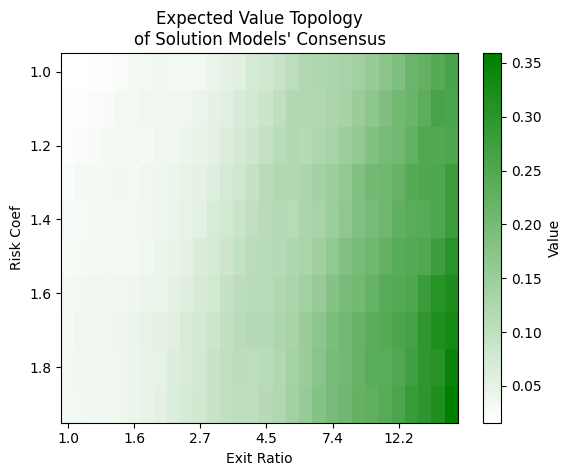

In [4]:
plot_heatmap(EV_arr)

In [24]:
import numpy as np
import matplotlib.pyplot as plt

def permutation_test_ev(
    y_true,
    y_pred,
    R: float,
    n_perm: int = 10000,
    seed: int | None = None,
    bins: int = 40,
    plot: bool = True,
):
    """
    Monte Carlo permutation test for Expected Value (EV) of binary predictions.

    EV = (R * precision - (1 - precision)), where R is a provided risk ratio.

    Parameters
    ----------
    y_true : array-like of shape (n_samples,)
        Ground-truth binary labels in {0,1}. np.nan allowed (ignored).
    y_pred : array-like of shape (n_samples,)
        Binary predictions in {0,1}. (If you have probabilities, threshold first.)
    R : float
        Risk ratio to weight precision in the EV formula.
    n_perm : int
        Number of label permutations.
    seed : int | None
        RNG seed for reproducibility.
    bins : int
        Histogram bins for the visualization.
    plot : bool
        If True, show a matplotlib figure.

    Returns
    -------
    results : dict
        {
          'actual_ev': float,
          'perm_mean': float,
          'perm_std': float,
          'p_value': float,        # one-sided, P(perm >= actual)
          'perm_evs': np.ndarray   # shape (n_perm,)
        }
    """
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    # Keep only valid entries (ignore NaNs in y_true)
    mask = (~np.isnan(y_true)) & np.isin(y_true, [0, 1]) & np.isin(y_pred, [0, 1])
    y_t = y_true[mask].astype(int)
    y_p = y_pred[mask].astype(int)

    if y_t.size == 0:
        raise ValueError("No valid samples after masking; check inputs.")

    def precision(tp, fp):
        denom = tp + fp
        return 0.0 if denom == 0 else tp / denom

    def ev_from_counts(tp, fp):
        ps = precision(tp, fp)
        return R * ps - (1 - ps)

    # Actual EV
    tp_actual = np.sum((y_t == 1) & (y_p == 1))
    fp_actual = np.sum((y_t == 0) & (y_p == 1))
    actual_ev = ev_from_counts(tp_actual, fp_actual)

    # Permutations
    rng = np.random.default_rng(seed)
    perm_evs = np.empty(n_perm, dtype=float)
    for i in range(n_perm):
        y_perm = rng.permutation(y_t)
        tp = np.sum((y_perm == 1) & (y_p == 1))
        fp = np.sum((y_perm == 0) & (y_p == 1))
        perm_evs[i] = ev_from_counts(tp, fp)

    # One-sided p-value
    p_value = (np.sum(perm_evs >= actual_ev) + 1.0) / (n_perm + 1.0)

    # Visualization
    if plot:
        fig, ax = plt.subplots(figsize=(7, 4.5))
        ax.hist(perm_evs, bins=bins, density=True, alpha=0.6, color="#a23900c5")

        # KDE
        x_min, x_max = float(np.min(perm_evs)), float(np.max(perm_evs))
        xs = np.linspace(x_min, x_max, 512)

        std = np.std(perm_evs)
        n = perm_evs.size
        bw = 1.06 * std * (n ** (-1 / 5)) if std > 0 else 0.05

        if bw > 0:
            diffs = (xs[:, None] - perm_evs[None, :]) / bw
            kde = np.mean(np.exp(-0.5 * diffs * diffs) / (np.sqrt(2 * np.pi) * bw), axis=1)
            ax.plot(xs, kde, linewidth=2, c='maroon')

        ax.axvline(actual_ev, linewidth=4, c="#0075B4")
        ax.set_xlabel("EV under label permutations")
        ax.set_ylabel("Density")
        ax.set_title("Permutation Test for Expected Value (EV)")
        ax.text(
            0.75, 0.95,
            f"actual={actual_ev:.4f}\np={p_value:.4g}\nmean={perm_evs.mean():.4f}",
            ha="right", va="top", transform=ax.transAxes
        )
        plt.tight_layout()
        plt.show()

    return {
        "actual_ev": float(actual_ev),
        "perm_mean": float(perm_evs.mean()),
        "perm_std": float(perm_evs.std(ddof=1)),
        "p_value": float(p_value),
        "perm_evs": perm_evs,
    }

# --- Example usage ---
# y_true = np.array([0,1,1,0,1,0,1,1,0,0])
# y_pred = np.array([0,1,0,0,1,0,1,0,0,1])
# res = permutation_test_ev(y_true, y_pred, R=2.0, n_perm=5000, seed=42, plot=True)
# print(res["p_value"], res["actual_ev"])


In [120]:
import serialization
data = serialization.load_deeplist(where='../../runs/run_147/ensemble.data')
e_forest = data[0]
e_params = data[1]
e_thresh = data[2]
e_freqs = data[3]
e_EVs = data[4]
print(e_thresh[-1])
print(len(e_forest))

0.16666666666666666
6


In [ ]:
import transforms
import evaluation
import numpy as np
import pandas as pd

data = pd.read_csv("../../data/ES15.csv")
x_raw = data.values
data_ext = pd.read_csv("../../data/ES15_ext.csv")
x_raw_ext = data_ext.values

xall = transforms.forest2features(e_forest, x_raw)
xall_ext = transforms.forest2features(e_forest, x_raw_ext)

R = np.exp(np.mean(e_params[1]))
r = np.mean(e_params[0])

yext = evaluation.generate_solarr_atrplr(x_raw_ext, r, np.log(R))
idx_ext = ~np.isnan(yext)
yext = yext[idx_ext]
xall_ext = xall_ext[idx_ext]

ytrue = evaluation.generate_solarr_atrplr(x_raw, r, np.log(R))
idx = ~np.isnan(ytrue)
ytrue = ytrue[idx]
xall = xall[idx]



xall = evaluation.binarize_features(xall, ytrue)
xall_ext = evaluation.binarize_features(xall_ext, yext)

In [75]:
print(type(yext), type(ypred_ext))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


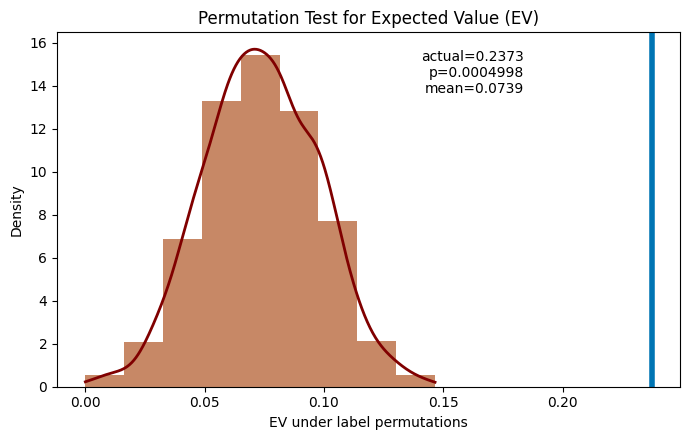

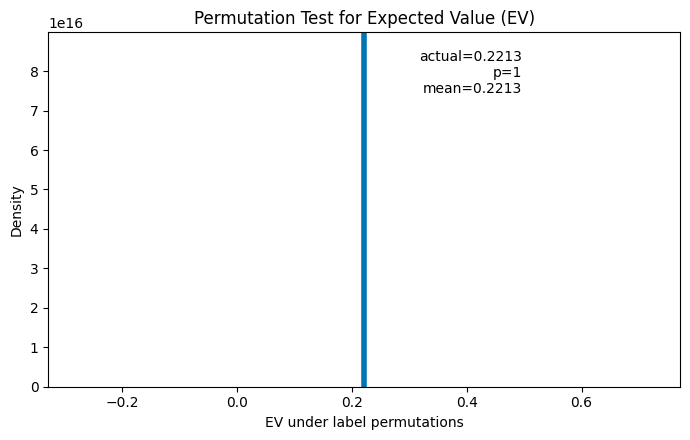

{'actual_ev': 0.2212971408929565,
 'perm_mean': 0.22129714089295652,
 'perm_std': 2.7756963498501774e-17,
 'p_value': 1.0,
 'perm_evs': array([0.22129714, 0.22129714, 0.22129714, ..., 0.22129714, 0.22129714,
        0.22129714])}

In [122]:
thr = e_thresh[-1]

ypred = evaluation.meta_bithreshold(xall, thr)
ypred_ext = evaluation.meta_bithreshold(xall_ext, thr)

permutation_test_ev(ytrue, ypred, R=R, n_perm=2000, bins=9)
#print(evaluation.solve_EV(ytrue, ypred, R))
permutation_test_ev(yext, ypred_ext, R=R, n_perm=10000, bins=9)
#print(evaluation.solve_EV(yext, ypred_ext, R))

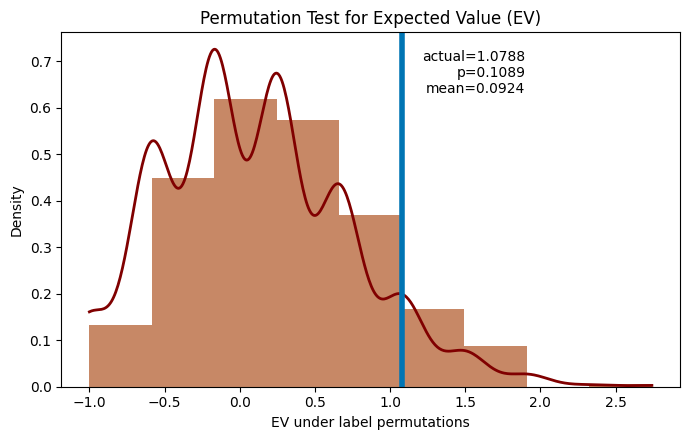

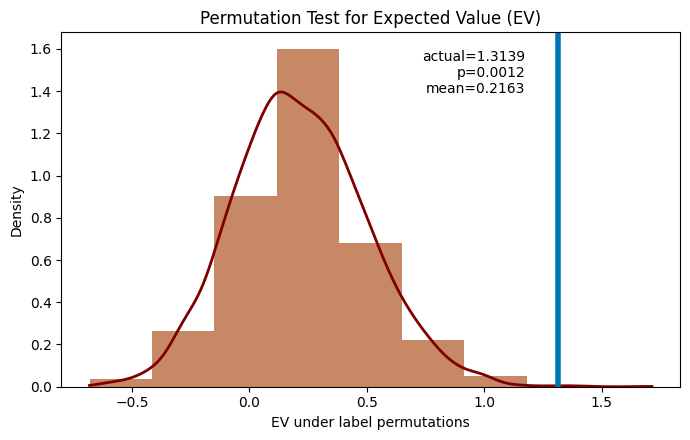

(array([0, 1]), array([8374,   99]))

In [124]:
thr2 = thr*3

ypred = evaluation.meta_bithreshold(xall, thr2)
ypred_ext = evaluation.meta_bithreshold(xall_ext, thr2)
permutation_test_ev(ytrue, ypred, R=R, n_perm=2000, bins=9)
#print(evaluation.solve_EV(ytrue, ypred, R))
permutation_test_ev(yext, ypred_ext, R=R, n_perm=5000, bins=9)
np.unique(ypred_ext, return_counts=True)
#print(evaluation.solve_EV(yext, ypred_ext, R))

In [ ]:
import serialization, transforms, evaluation
import pandas as pd
import numpy as np

allperfs = []
allEVs = []
allFreqs = []
allpvals = []
initthrs = []

data_ext = pd.read_csv("../../data/ES15_ext.csv")
x_raw_ext = data_ext.values


for i in range(145, 179):
    print(i)
    where = str(i)
    if i==170:
        continue
    try:
        data = serialization.load_deeplist(where='../../runs/run_'+where+'/ensemble.data')
        #print(data[1:])
    except Exception as e:
        print(e)
        continue
    e_forest = data[0]
    e_params = data[1]
    e_thresh = data[2]
    e_freqs = data[3]
    e_EVs = data[4]

    xall_ext = transforms.forest2features(e_forest, x_raw_ext)

    R = np.exp(np.mean(e_params[1]))
    r = np.mean(e_params[0])

    
    yext = evaluation.generate_solarr_atrplr(x_raw_ext, r, np.log(R))
    idx_ext = ~np.isnan(yext)
    yext = yext[idx_ext]
    xall_ext = xall_ext[idx_ext]
    xall_ext = evaluation.binarize_features(xall_ext, yext)

    perf = evaluation.ensemble_performance_scarcethresh(xall_ext, yext, e_thresh[-1], R)
    perf = np.asarray(perf)
    if(perf.size == 0):
        continue

    for i in range(perf.shape[0]):
        #EV
        if(perf[i, 1] == -1):
            allEVs.append(perf[:i])
            break
        elif(i == perf.shape[0]-1):
            allEVs.append(perf[:i+1])

    for i in range(perf.shape[0]):
        #freq
        if(perf[i, 2] == 0):
            allFreqs.append(perf[:i])
            break
        elif(i == perf.shape[0]-1):
            allFreqs.append(perf[:i+1])

    for i in range(1, perf.shape[0]):
        #p values
        if(perf[i, 3] > perf[i-1, 3] and perf[i, 3] == 1):
            allpvals.append(perf[:i])
            break
        elif(i == perf.shape[0]-1):
            allpvals.append(perf[:i+1])

    initthrs.append(e_thresh[-1])
    allperfs.append(perf)
    

In [6]:
len(allperfs)

29

In [ ]:
import visualization

datasets = []
for perf in allEVs:
    datasets.append((perf[:, 0], perf[:, 1]))

_, _ = visualization.plot_spec_ensemble_performances(datasets, info='EV')

In [ ]:
datasets = []
for perf in allpvals:
    datasets.append((perf[:, 0], perf[:, 3]))

_, _ = visualization.plot_spec_ensemble_performances(datasets, info='P-Value')

In [ ]:
datasets = []
for perf in allFreqs:
    datasets.append((perf[:, 0], perf[:, 2]))
    
_, _ = visualization.plot_spec_ensemble_performances(datasets, info='Frequency')

In [ ]:
import visualization
for i in e_forest:
    some_tree = i
    latexstr = visualization.to_latex(some_tree)
    visualization.render_latex(latexstr)

In [432]:
import matplotlib as mpl

mpl.rcParams.update(mpl.rcParamsDefault)   # reset all rcParams to defaults

In [16]:
import numpy as np
from sklearn.metrics import precision_score

def permutation_test_ev_single(y_true, y_pred, R, n_perm=2000, seed=None):
    """
    Compute permutation p-value for EV at a single prediction vector.
    """
    rng = np.random.default_rng(seed)
    mask = (~np.isnan(y_true))
    y_t = y_true[mask].astype(int)
    y_p = y_pred[mask].astype(int)

    def precision(tp, fp):
        denom = tp + fp
        return 0.0 if denom == 0 else tp / denom

    def ev_from_counts(tp, fp):
        ps = precision(tp, fp)
        return R * ps - (1 - ps)

    # Actual EV
    tp_actual = np.sum((y_t == 1) & (y_p == 1))
    fp_actual = np.sum((y_t == 0) & (y_p == 1))
    actual_ev = ev_from_counts(tp_actual, fp_actual)

    # Permutations
    perm_evs = np.empty(n_perm, dtype=float)
    for i in range(n_perm):
        y_perm = rng.permutation(y_t)
        tp = np.sum((y_perm == 1) & (y_p == 1))
        fp = np.sum((y_perm == 0) & (y_p == 1))
        perm_evs[i] = ev_from_counts(tp, fp)

    # One-sided p-value
    p_value = (np.sum(perm_evs >= actual_ev) + 1.0) / (n_perm + 1.0)
    return p_value


def build_pval_grid(x_raw, best_trees, m=10, n=30, 
                    yffset=10, xffset=0, yscale=10, xscale=10, 
                    n_perm=2000, seed=None):
    """
    Builds a grid of permutation test p-values for EV.
    """
    from sklearn.metrics import precision_score
    xall = np.asarray(best_trees).T
    pval_arr = np.empty((m, n))

    for i in range(yffset, m+yffset):
        for j in range(xffset, n+xffset):

            atrthr = i / yscale
            ln_plr = j / xscale

            # Generate candidate solution
            y_ = evaluation.generate_solarr_atrplr(x_raw, atrthr, ln_plr)
            idx = ~np.isnan(y_)
            y_ = y_[idx]

            # Candidate predictions
            pvpred = evaluation.meta_bipopvote(xall[idx], threshold=0.99)

            # Precision
            ps = precision_score(y_, pvpred)

            # Risk ratio
            R = float(np.exp(ln_plr))

            # Permutation test for EV → p-value
            pval = permutation_test_ev_single(y_, pvpred, R, n_perm=n_perm, seed=seed)

            # Store in array
            pval_arr[i-yffset, j-xffset] = pval

    return pval_arr


In [17]:
pval_grid = build_pval_grid(x_raw, best_trees, m=10, n=30,
    yffset=10, xffset=0,
    yscale=10, xscale=10,
    n_perm=1000,  # more perms = smoother p-values
    seed=None)

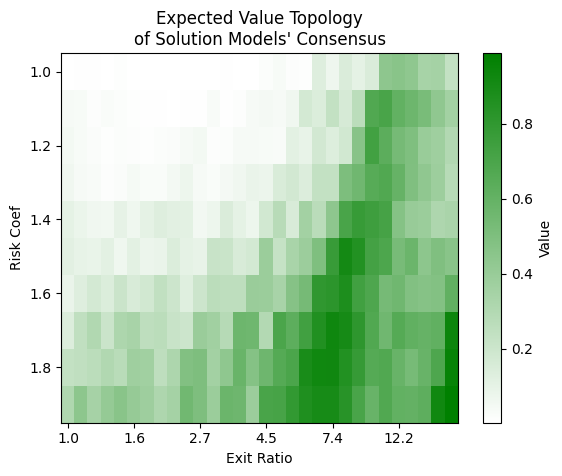

In [20]:
plot_heatmap(pval_grid)

In [41]:
lnplr = 10

y_ = evaluation.generate_solarr_atrplr(x_raw, 1, np.log(lnplr))
idx = ~np.isnan(y_)

y_ = y_[idx]
pvpred = evaluation.meta_bipopvote(xall[idx], threshold=0.99)

v, c = np.unique(pvpred, return_counts=True)
print(v, c)
ps = precision_score(y_, pvpred)
print(ps)

[0 1] [61854 30729]
0.10615379608838556


In [27]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm
from matplotlib.cm import ScalarMappable
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
from mpl_toolkits.axes_grid1 import make_axes_locatable

def visualize_loss_topology_3d_heatmap(
    Z: np.ndarray,
    title: str = "3D Heatmap (Desirability)",
    extent: tuple | None = None,      # (xmin, xmax, ymin, ymax)
    elev: float = 35,
    azim: float = 135,
    stride: int = 1,                   # plot every Nth point
    nan_color: str = "#FFFFFF",
    dpi: int = 160,
    ticks: list[float] | None = None   # custom colorbar ticks (optional)
):
    """
    Plots a 3D surface colored as a 'heatmap' with:
      - red↔white↔green when data spans negative and positive (center at 0)
      - white→green when all non-negative
      - red→white when all non-positive

    Z: 2D array (can include NaNs)
    """

    # ---- validate & prep ----
    Z = np.asarray(Z, dtype=float)
    if Z.ndim != 2:
        raise ValueError("Z must be 2D.")
    if not np.isfinite(Z).any():
        raise ValueError("Z contains no finite values.")

    m, n = Z.shape
    if extent is None:
        x = np.arange(n); y = np.arange(m)
    else:
        xmin, xmax, ymin, ymax = extent
        x = np.linspace(xmin, xmax, n)
        y = np.linspace(ymin, ymax, m)
    X, Y = np.meshgrid(x, y)

    data_min = float(np.nanmin(Z))
    data_max = float(np.nanmax(Z))

    # ---- colormap + normalization per your spec ----
    if data_min < 0 < data_max:
        cmap = LinearSegmentedColormap.from_list("r_w_g", ["#7F0000", "#F0F0F0", "#0087B4"])
        norm = TwoSlopeNorm(vmin=data_min, vcenter=0.0, vmax=data_max)
    elif data_min >= 0:
        cmap = LinearSegmentedColormap.from_list("r_w_g", ["#0087B4", "white", "#7F0000"])
        norm = TwoSlopeNorm(vmin=data_min, vcenter=0.05, vmax=data_max)
    else:  # data_max <= 0
        cmap = LinearSegmentedColormap.from_list("r_w", ["red", "white"])
        norm = plt.Normalize(vmin=data_min, vmax=data_max)

    cmap.set_bad(nan_color)

    # ---- optional downsample for speed ----
    sl = slice(0, None, max(1, stride))
    Xs, Ys, Zs = X[sl, sl], Y[sl, sl], Z[sl, sl]

    # ---- figure (no constrained/tight layout to avoid colorbar engine clashes) ----
    fig = plt.figure(figsize=(8, 6), dpi=dpi)
    ax = fig.add_subplot(111, projection="3d")

    # 3D surface colored by heatmap scheme
    surf = ax.plot_surface(
        Xs, Ys, Zs,
        cmap=cmap, norm=norm,
        linewidth=0, antialiased=True, shade=True
    )

    # ---- stable colorbar on a dedicated axis ----
    sm = ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array(Z)
    sm.set_clim(data_min, data_max)
    cbar = fig.colorbar(sm, ax=ax, shrink=0.8, pad=0.1)

    # default ticks: min, (−1 if in-range), 0 if in-range, max — or user-supplied
    if ticks is None:
        candidates = [data_min, 0.0, data_max]
        # include -1 only if it lies within [data_min, data_max]
        if data_min <= -1.0 <= data_max:
            candidates.insert(1, -1.0)
        ticks = sorted(set(t for t in candidates if data_min <= t <= data_max))

    cbar.set_ticks(ticks)
    # friendly labels
    labels = []
    for t in ticks:
        if np.isclose(t, 0.0) and (data_min < 0 < data_max):
            labels.append("neutral (0)")
        elif np.isclose(t, -1.0):
            labels.append("worst (-1)")
        elif np.isclose(t, data_min):
            labels.append(f"min ({t:g})")
        elif np.isclose(t, data_max):
            labels.append(f"max ({t:g})")
        else:
            labels.append(f"{t:g}")
    cbar.set_ticklabels(labels)
    cbar.set_label("Desirability (higher is better)")

    # ---- view & axes ----
    ax.set_title(title, pad=10)
    if extent is not None:
        ax.set_xlim(x.min(), x.max()); ax.set_ylim(y.min(), y.max())
    ax.view_init(elev=elev, azim=azim)

    plt.show()


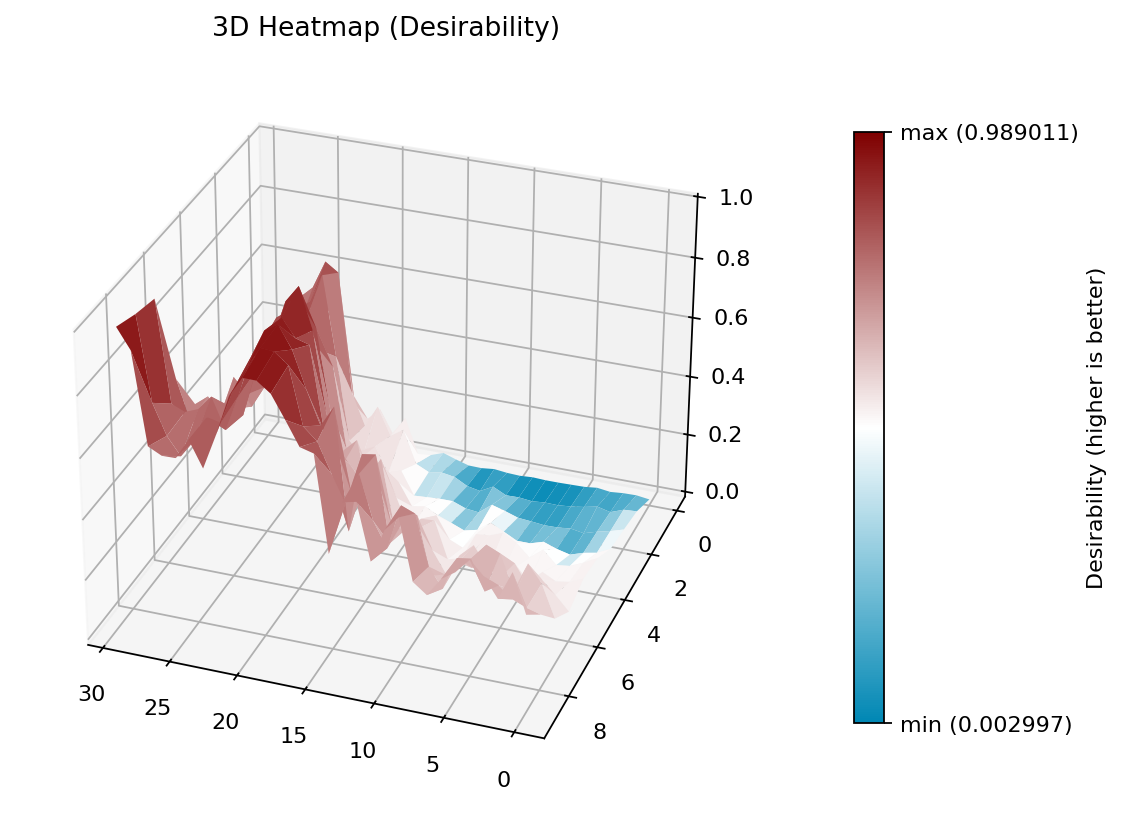

In [28]:
visualize_loss_topology_3d_heatmap(pval_grid, elev=30, azim=110)

In [48]:
import numpy as np

def shapley_ev_allvote(
    X: np.ndarray,           # (n_samples, n_models) in {0,1}
    y_true: np.ndarray,      # (n_samples,) in {0,1}
    R: float = 6.0,
    n_permutations: int = 256,
    seed: int | None = None,
    return_kind: str = "both"   # "both", "shapley", or "importance"
):
    """
    Monte Carlo Shapley values for model contributions to an ALL-vote (AND) ensemble,
    where coalition predictions are 1 iff *all* included models predict 1.
    Score = EV from precision: EV = (R+1)*P - 1.

    Returns
    -------
    If return_kind == "both": dict with keys:
        - "shapley": np.ndarray (n_models,) raw Shapley contributions (EV units)
        - "importance": np.ndarray (n_models,) normalized to [0,1] (positive part)
        - "ev_full": float, EV of the full coalition (all models)
    If "shapley": np.ndarray (n_models,)
    If "importance": np.ndarray (n_models,)
    """
    X = (X.astype(np.uint8) != 0)
    y = (np.asarray(y_true).astype(np.uint8) != 0)

    rng = np.random.default_rng(seed)
    n_samples, n_models = X.shape

    # ---- helper to compute EV from TP/FP (precision-only) ----
    def ev_from_counts(tp: float, fp: float) -> float:
        denom = tp + fp
        if denom <= 0.0:
            return 0.0
        P = tp / denom
        return P * (R + 1.0) - 1.0

    # Precompute full-coalition EV (AND across all models)
    p_full = X.all(axis=1)
    tp_full = float(np.sum(p_full & y))
    fp_full = float(np.sum(p_full & (~y)))
    ev_full = ev_from_counts(tp_full, fp_full)

    # For incremental updates, we keep the current coalition mask (boolean over samples)
    # and track EV via TP/FP counts for that mask.
    # NOTE: Base coalition (empty set) uses vacuous truth for AND → all True mask.
    # Adding first model j yields mask = X[:, j], as desired.

    shapley_sum = np.zeros(n_models, dtype=np.float64)

    # Optional precomputations to reduce repeated ANDs with y / ~y
    X_and_y    = X & y[:, None]     # shape: (n_samples, n_models)
    X_and_ny   = X & (~y)[:, None]

    for _ in range(n_permutations):
        order = rng.permutation(n_models)

        # start from empty coalition (mask = all True)
        mask = np.ones(n_samples, dtype=bool)
        # counts for empty coalition
        tp_cur = float(np.sum(mask & y))
        fp_cur = float(np.sum(mask & (~y)))
        ev_cur = ev_from_counts(tp_cur, fp_cur)

        for j in order:
            # New mask = old mask AND model j's predictions
            # We need TP/FP for the new mask quickly.
            # TP_next = sum(mask & X[:,j] & y) = sum((mask & y) & X[:,j])
            # FP_next = sum(mask & X[:,j] & ~y) = sum((mask & ~y) & X[:,j])

            # Compute masked sums via boolean indexing (fast in NumPy)
            # First restrict to current mask; then sum X_and_y / X_and_ny columns j
            idx = mask
            tp_next = float(np.sum(X_and_y[idx, j]))
            fp_next = float(np.sum(X_and_ny[idx, j]))

            ev_next = ev_from_counts(tp_next, fp_next)
            marginal = ev_next - ev_cur
            shapley_sum[j] += marginal

            # Advance coalition
            # (mask & X[:, j]) updates in-place efficiently
            mask[idx] &= X[idx, j]
            tp_cur, fp_cur, ev_cur = tp_next, fp_next, ev_next

    shapley = shapley_sum / float(n_permutations)

    # Importance on [0,1]: normalize positive contributions
    pos = np.clip(shapley, 0.0, None)
    imax = pos.max()
    importance = (pos / imax) if imax > 0 else np.zeros_like(pos)

    if return_kind == "shapley":
        return shapley
    if return_kind == "importance":
        return importance
    return {"shapley": shapley, "importance": importance, "ev_full": ev_full}


In [ ]:
imporances = shapley_ev_allvote(xall, ytrue, return_kind="both")

In [52]:
importances= shapley_ev_allvote(xall_ext, yext, return_kind="both")

In [73]:
print(imporances['shapley'])
print(imporances['shapley'].sum())
print(imporances['ev_full'])

[ 0.011105 -0.000287 -0.000106 -0.000202 -0.000124 -0.000246  0.000803
  0.000312  0.000045  0.001806 -0.000632  0.014655  0.001872  0.000383
 -0.000046  0.001212  0.002157 -0.000046  0.000853  0.000907  0.001287
  0.001959  0.001449 -0.000117  0.000558 -0.000252  0.000231  0.000998
  0.000416  0.000026  0.000142 -0.002652 -0.000081  0.000114  0.00202
  0.002047]
0.04256421861363681
0.12129765140427917


In [68]:
np.set_printoptions(suppress=True, precision=6)
print(importances['shapley'])

[ 0.002375 -0.000314  0.003371 -0.000547  0.003376  0.005041 -0.000451
  0.001609  0.000878  0.230627  0.004543  0.00007   0.001485  0.004148
  0.001977  0.005831  0.002477  0.006927  0.00235   0.001945  0.001444
  0.001915  0.015929  0.002615  0.008896  0.002355  0.009959 -0.004159
 -0.000432  0.001919  0.001073  0.010901  0.001292  0.001594  0.000031
  0.002291]


In [20]:
newidx = np.where(imporances > 0)

In [22]:
print(newidx)
print(imporances[newidx])

(array([ 0,  4,  7, 11, 16, 32]),)
[0.67823987 0.00561205 0.02524808 1.         0.04771713 0.00471015]


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(xall, y_, test_size=0.3, shuffle=True, random_state=0)
#scaler = StandardScaler()
#X_train = scaler.fit_transform(X_train)
#X_test = scaler.transform(X_test)

In [ ]:
model, history = evaluation.standard_NN_construction(X_train, y_train, epochs=50, verbose=1)
evaluation.standard_NN_evaluation(X_train, X_test, y_train, y_test, model, history, run_dir='', vizout=False, show=True)

In [ ]:
np.unique(preds, return_counts=True)

In [ ]:
pd.DataFrame(x_[:, 0]).hist(bins=200)

In [ ]:
transforms.get_oplist(forest[0])

In [ ]:
for i in range(1,1):
    print('hello')

In [ ]:
import serialization
import matplotlib.pyplot as plt

path, scores = serialization.load_deeplist(where='../../runs/run_26/path_pscr.hstry')

plt.plot(range(len(scores)), scores)

In [ ]:
data = pd.read_csv("../../data/ES15.csv")
x_raw = data.values
best_forest = serialization.load_forest(where='../../runs/run_49/best.4st')
import optimize
x_ = transforms.forest2features(
    population=best_forest,
    x_raw=x_raw
)
_, __, best_scores = evaluation.evaluate_forest_newer(x_, close_prices=x_raw[:, 3], lag_range=(1, 3))
loss = optimize.loss_fc(best_scores)
print(loss)

for i in range(len(best_forest)):
    print(transforms.get_oplist(best_forest[i]))

In [ ]:
from sklearn.linear_model import LogisticRegression
# label train‐vs‐test rows
X_tv = np.vstack([X_train, X_test])
y_tv = np.array([0]*len(X_train) + [1]*len(X_test))
adv = LogisticRegression().fit(X_tv, y_tv)
print("AUC distinguishing train vs test:", adv.score(X_tv, y_tv))

In [ ]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from transforms import forest2features

# 1) Define the transformer that wraps your feature generator
class Forest2Features(BaseEstimator, TransformerMixin):
    def __init__(self, population):
        self.population = population

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # X is your raw x_raw array (n_samples, 4)
        return forest2features(self.population, X)

# 2) Prepare your raw data and target
#    Assume x_raw is an (N, 4) ndarray and best_forest is defined
#    Column 2 is the 'close' price
raw_prices = x_raw[:, 3]
# compute 1-step log-return target of length N-1
y_logret = np.log(raw_prices[1:] / raw_prices[:-1])
# align features by dropping the last raw row so X_raw_aligned.shape[0] == y_logret.shape[0]
X_raw_aligned = x_raw[:-1, :]

noise = np.random.rand(X_raw_aligned.shape[0], 1)

X_raw_aligned = np.hstack([X_raw_aligned, noise])

# 3) Build the pipeline
pipe = Pipeline([
    ("fe",     Forest2Features(population=best_forest)),
    ("scaler", StandardScaler()),
    ("lr",     LinearRegression())
])

# 4) Time-series cross-validation
tscv = TimeSeriesSplit(n_splits=3)
for fold, (train_idx, test_idx) in enumerate(tscv.split(X_raw_aligned), 1):
    X_tr, X_te = X_raw_aligned[train_idx], X_raw_aligned[test_idx]
    y_tr, y_te = y_logret     [train_idx], y_logret     [test_idx]

    #y_tr = np.random.permutation(y_tr)

    pipe.fit(X_tr, y_tr)
    
    perm = permutation_importance(pipe,
                              X_tr, y_tr,
                              n_repeats=5,
                              random_state=0,
                              scoring='r2')
    perm_importances = pd.Series(perm.importances_mean)
    print(perm_importances)
    #print("impt: ",perm_importances.max(),perm_importances[4])

    score = pipe.score(X_te, y_te)
    y_pred = pipe.predict(X_te)
    visualization.visualize_regression_eval(y_te, y_pred, show=False)
    print(f"Fold {fold} R²: {score:.4f}")


In [ ]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from transforms import forest2features

# 1) Define transformer wrapping your feature generator\class Forest2Features(BaseEstimator, TransformerMixin):
def __init__(self, population):
    self.population = population

def fit(self, X, y=None):
        return self

def transform(self, X):
        return forest2features(self.population, X)

# 2) Prepare raw data and target
#    Assume x_raw is an (N, 4) ndarray and best_forest is defined; column 2 is 'close'
raw_prices = x_raw[:, 3]
# compute 1-step log-return target of length N-1
y_logret = np.log(raw_prices[1:] / raw_prices[:-1])
# align features by dropping the last raw row so X_raw_aligned.shape[0] == y_logret.shape[0]
X_raw_aligned = x_raw[:-1, :]

# 3) Build pipeline
pipe = Pipeline([
    ("fe",     Forest2Features(population=best_forest)),
    ("scaler", StandardScaler()),
    ("lr",     LinearRegression())
])

# 4) Time-series cross-validation with post-feature-generation printing
tscv = TimeSeriesSplit(n_splits=5)
for fold, (train_idx, test_idx) in enumerate(tscv.split(X_raw_aligned), start=1):
    print(f"\n--- Fold {fold} ---")

    # raw train/test splits
    X_tr_raw, X_te_raw = X_raw_aligned[train_idx], X_raw_aligned[test_idx]
    y_tr,      y_te     = y_logret[train_idx],      y_logret[test_idx]

    # generate features using the transformer step
    fe = pipe.named_steps['fe']
    X_te_feats = fe.transform(X_te_raw)

    # inspect the generated features for the test split
    print("First 3 rows of generated test features:")
    print(X_te_feats[:3])
    print("Last 3 rows of generated test features:")
    print(X_te_feats[-3:])

    # fit the full pipeline (features -> scaler -> model)
    pipe.fit(X_tr_raw, y_tr)
    score = pipe.score(X_te_raw, y_te)
    print(f"Fold {fold} R²: {score:.4f}")


In [ ]:
dataext = pd.read_csv("../../data/ES15_ext.csv")
x_ext = dataext.values

xext_ = transforms.forest2features(
    population=best_forest,
    x_raw=x_ext
)

noise = np.random.rand(xext_.shape[0], 1)

xext_ = np.hstack([xext_, noise])


xext_ = scaler.transform(xext_)

ynewe = np.roll(x_ext[:, 3], shift=-1)
#np.random.shuffle(ynewe)
y_e = np.log(ynewe / x_ext[:, 3])

evaluation.standard_LM_evaluation(X_train, xext_, y_train, y_e, model, dirpath, vizout=True, show=True)


In [ ]:
scores = []

for i in range(6,x_raw.shape[0] -1):
    x_i = transforms.forest2features(
        population=best_forest,
        x_raw=x_raw[:i]
    )
    
    x_i[:, 0] = 1

    y_i = np.log( x_raw[1:i, 3] / x_raw[:i-1, 3] )
    
    x_i = np.hstack([x_i, np.random.rand(i, 1)])
    x_i = x_i[:-1]
    
    x_i = scaler.transform(x_i)
    
    print(model.score(x_i, y_i))

In [ ]:
x = pd.read_csv("../../data/ES15_ext.csv")
xr = x.values

x = transforms.forest2features(
    population=best_forest,
    x_raw=xr
)

x[:, 0] = 1
noise = np.random.rand(x.shape[0], 1)

x = np.hstack([x, noise])

x = scaler.transform(x)

ynewe = np.roll(xr[:, 3], shift=-1)
#np.random.shuffle(ynewe)
y = (ynewe / xr[:, 3]) - 1

pred = model.predict(x)

evaluation.standard_LM_evaluation(x, x, y, y, model, dirpath, vizout=True, show=True)


In [ ]:
mask = np.abs(model.predict(X_test)) > 0.0005
frac = mask.mean()
print(frac)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def sign_accuracy_comparative(y_true, y_pred, show=True):
    """
    Plot two accuracy curves versus |y_pred| threshold, starting at 0.00025,
    and restrict x-axis to [0, 0.0025].

    - 'center': accuracy for predictions with |y_pred| <= threshold
    - 'extremes': accuracy for predictions with |y_pred| >= threshold

    Args:
        y_true: array-like of true values
        y_pred: array-like of predicted values
        show: whether to display the plot

    Returns:
        thresholds: filtered array of |y_pred| thresholds (>=0.00025)
        center_acc: accuracy for |y_pred| <= threshold
        extremes_acc: accuracy for |y_pred| >= threshold
    """
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    abs_pred = np.abs(y_pred)
    true_sign = np.sign(y_true)
    pred_sign = np.sign(y_pred)

    # All unique thresholds, sorted ascending
    all_thresholds = np.unique(abs_pred)
    all_thresholds.sort()

    # Start at a more stable region: ignore thresholds below 0.00025
    thresholds = all_thresholds[all_thresholds >= 0.0001]

    # Compute accuracies at each filtered threshold
    center_acc = np.array([
        np.mean(true_sign[abs_pred <= t] == pred_sign[abs_pred <= t])
        for t in thresholds
    ])
    extremes_acc = np.array([
        np.mean(true_sign[abs_pred >= t] == pred_sign[abs_pred >= t])
        for t in thresholds
    ])

    if show:
        plt.figure()
        plt.plot(thresholds, center_acc, marker='o', linestyle='-',
                 label='|y_pred| ≤ threshold (center)')
        plt.plot(thresholds, extremes_acc, marker='^', linestyle='--',
                 label='|y_pred| ≥ threshold (extremes)')
        plt.xlabel("|y_pred| Threshold")
        plt.ylabel("Sign Prediction Accuracy")
        plt.title("Accuracy from Center vs. Extremes (from 0.00025)")
        plt.legend()
        plt.xlim(0.0001, 0.0025)
        plt.show()

    return thresholds, center_acc, extremes_acc


In [ ]:
y_pred_test = model.predict(X_test)
sign_accuracy_comparative(y_test, y_pred_test)


In [ ]:
_ = sign_accuracy_comparative(y, pred)

In [ ]:


for i in range(1,len(xr)):
    p = round(model.predict(x[:i])[-1], 5)
    if(abs(p) > 0.0005):
        print(f'time: {xr[i, 0]}\tprice: {xr[i]}\tpred: {p}')